## Imports

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from scipy.stats import multivariate_normal
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


### Preprocessing and getting data

Same as for q2 as same dataset

In [18]:
df = pd.read_csv('./dataset/Clustering_dataset(in).csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19.0,15.0,39.0
1,2,Male,21.0,NaN,81.0
2,3,Female,20.0,16.0,6.0
3,4,Female,23.0,16.0,77.0
4,5,Female,31.0,17.0,40.0


In [19]:
df['Genre'] = df['Genre'].fillna(df['Genre'].mode()[0])

In [20]:
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Annual Income (k$)'] = df['Annual Income (k$)'].ffill()
df['Spending Score (1-100)'] = df['Spending Score (1-100)'].fillna(df['Spending Score (1-100)'].median())

In [21]:
#### updating the genre to 0 and 
df['Gender'] = df['Genre'].map({'Male':1,'Female':0})


In [22]:
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Gender
0,1,Male,19.0,15.0,39.0,1
1,2,Male,21.0,15.0,81.0,1
2,3,Female,20.0,16.0,6.0,0
3,4,Female,23.0,16.0,77.0,0
4,5,Female,31.0,17.0,40.0,0


In [23]:
class multivariate_normal:
    """
    Custom implementation of the multivariate normal probability density function.
    This version is vectorized to handle a matrix of inputs.
    """
    def __init__(self, mean, cov):
        self.mean = np.array(mean)
        self.cov = np.array(cov)
        self.d = len(mean)
        
        try:
            # Add a small regularization value (jitter) to the diagonal for stability
            self.inv_cov = np.linalg.inv(self.cov + np.eye(self.d) * 1e-6)
            self.det_cov = np.linalg.det(self.cov + np.eye(self.d) * 1e-6)
        except np.linalg.LinAlgError:
            # Fallback for severe singularity
            self.inv_cov = np.linalg.inv(self.cov + np.eye(self.d) * 1e-4)
            self.det_cov = np.linalg.det(self.cov + np.eye(self.d) * 1e-4)

    def pdf(self, X):
        """
        Calculates the probability density function for each row in a matrix X.
        
        Args:
            X (np.ndarray): The data matrix of shape (n_samples, d).
            
        Returns:
            np.ndarray: An array of probability densities of shape (n_samples,).
        """
        X = np.array(X)
        
        # Ensure X is always 2D, even for single samples
        if X.ndim == 1:
            X = X.reshape(1, -1)
        
        # 1. Normalization constant (this is a scalar and remains the same)
        norm_const = 1.0 / np.sqrt(((2 * np.pi)**self.d) * self.det_cov)
        
        # 2. Vectorized Mahalanobis distance
        #    x_minus_mu will have shape (n_samples, d)
        x_minus_mu = X - self.mean
        
        # This is the key change. It calculates the Mahalanobis distance
        # for each row in x_minus_mu and returns an array of shape (n_samples,).
        mahalanobis_dist = np.sum((x_minus_mu @ self.inv_cov) * x_minus_mu, axis=1)
        
        # 3. Exponential term (this will be an array)
        exp_term = np.exp(-0.5 * mahalanobis_dist)
        
        # 4. Combine them to get the final PDF values
        result = norm_const * exp_term
        
        # If input was single sample, return scalar instead of array
        if result.shape[0] == 1:
            return result[0]
        return result

## 3.1 Implementing GMM Class

In [24]:
class GMM:

    def __init__(self, df, n_clusters=3, max_iters=1000):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        # self.tol = tol
        self.random_state = 42
        
        # Store as NumPy array for clean math
        self.X = df.to_numpy() if hasattr(df, "to_numpy") else np.array(df)
        self.n_samples, self.n_features = self.X.shape

        self.means = []
        self.covariances = []
        self.mix_coeff = []
        self.resp = None
        self.likelihood = []

    def _add_watermark(self, ax):
        """Helper to add watermark to a plot."""
        ax.text(0.95, 0.95, "nidhish.jain",
                ha='right', va='top',
                transform=ax.transAxes,
                fontsize=10, color='gray', alpha=0.7)
        

    def __initialize_fit(self):
        np.random.seed(self.random_state)
        random_idx = np.random.choice(self.n_samples, self.n_clusters, replace=False)
        self.means = self.X[random_idx]
        self.covariances = [np.eye(self.n_features) for _ in range(self.n_clusters)]
        self.mix_coeff = np.full(self.n_clusters, 1 / self.n_clusters)
    
    def get_log_likelihood(self):
        """Compute log-likelihood to avoid underflow."""
        total_log_likelihood = 0
        for i in range(self.n_samples):
            prob = 0
            for k in range(self.n_clusters):
                distrib = multivariate_normal(mean=self.means[k], cov=self.covariances[k])
                prob += self.mix_coeff[k] * distrib.pdf(self.X[i])
            total_log_likelihood += np.log(prob + 1e-12)  # epsilon for safety
        return total_log_likelihood
    
    def drawLikelihood(self):
        plt.plot(range(len(self.likelihood)), self.likelihood)
        plt.xlabel('Iterations')
        plt.ylabel('Log-Likelihood')
        plt.title(f'Log-Likelihood vs Iterations for number of clusters = {self.n_clusters}')
        ax = plt.gca()
        self._add_watermark(ax)
        plt.show()
    
    def getLikelihood(self):
        return self.likelihood[-1] if self.likelihood else None
    def fit(self):
        self.__initialize_fit()
        likelihood = []

        for _ in range(self.max_iters):
            # ---------- E-step ----------
            weighted_probs = np.zeros((self.n_samples, self.n_clusters))
            for k in range(self.n_clusters):
                distrib = multivariate_normal(mean=self.means[k], cov=self.covariances[k])
                weighted_probs[:, k] = self.mix_coeff[k] * distrib.pdf(self.X)
            
            denominator = np.sum(weighted_probs, axis=1, keepdims=True)
            ## axis= 0 means we sum along each row so in  end we will have (col,) vector where each element will have the sum across cols
            ### axis = 1 means we sum along each column so in the end we will have (row,) vector where each element will have the sum across rows
            resp = weighted_probs / denominator
            self.resp = resp

            # ---------- M-step ----------
            N_k = np.sum(resp, axis=0)
            for k in range(self.n_clusters):
                # Update mean
                self.means[k] = np.sum(resp[:, k][:, np.newaxis] * self.X, axis=0) / N_k[k]
                ###resp[:, k] is of shape (n_samples,) so to do multiplication we do multiply it wth shape (n_samples, 1) so that it can be broadcasted to (n_samples, n_features)
                # Update covariance
                diff = self.X - self.means[k]
                self.covariances[k] = (resp[:, k][:, np.newaxis] * diff).T @ diff / N_k[k]
                # Update mixing coefficient
                self.mix_coeff[k] = N_k[k] / self.n_samples

            # ---------- Likelihood ----------
            log_likelihood = self.get_log_likelihood()
            likelihood.append(log_likelihood)

        self.likelihood = likelihood

    def getMembership(self):
        ### have to return probablity of each poi\
        # membership = np.zeros((self.n_samples, self.n_clusters))
        # for i in range(self.n_samples):
        #     for k in range(self.n_clusters):
        #         distrib = multivariate_normal(mean=self.means[k], cov=self.covariances[k])
        #         membership[i, k] = self.mix_coeff[k] * distrib.pdf(self.X[i])
        #     membership[i, :] /= np.sum(membership[i, :])  # Normalize to get probabilities
        # return membership ### shouldnt we just return self.resp??
        return self.resp

In [25]:
df_without_categ = df.drop(columns=['Genre','Gender','CustomerID'])
df_scaled = StandardScaler().fit_transform(df_without_categ)
df_scaled = pd.DataFrame(df_scaled, columns=df_without_categ.columns)
df_scaled.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,-1.426021,-1.738578,-0.441003
1,-1.280879,-1.738578,1.192342
2,-1.353450,-1.700410,-1.724346
3,-1.135737,-1.700410,1.036786
4,-0.555168,-1.662241,-0.402114


In [26]:
gmm_obj1= GMM(df_scaled, n_clusters=5, max_iters=100)
gmm_obj1.fit()

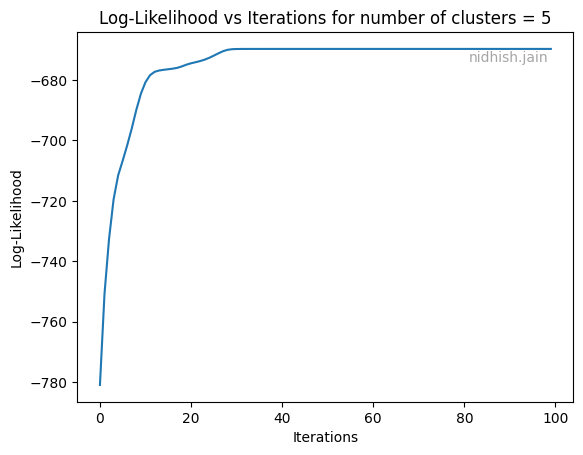

In [27]:
gmm_obj1.drawLikelihood()

In [28]:
membership = gmm_obj1.getMembership()
print(membership[:5])

[[1.33688003e-09 7.90523752e-05 9.99920946e-01 4.10911383e-11
  5.18704062e-16]
 [3.84824458e-07 9.99999588e-01 2.72110678e-08 5.81607202e-33
  8.28631350e-11]
 [8.90413145e-16 1.40804981e-14 9.99769436e-01 2.30564194e-04
  1.48279456e-61]
 [2.77227303e-06 9.99996959e-01 2.56003877e-07 6.07695324e-30
  1.27488335e-08]
 [1.04968134e-05 3.33893115e-04 9.99655610e-01 3.37600789e-10
  4.32798353e-14]]


In [29]:
likelihood = gmm_obj1.getLikelihood()
print(f"the log likelihood for this dataset is - {likelihood}")

the log likelihood for this dataset is - -669.6731041764932


here one crazy observation is that one cluster is having a very high membership >0.99 for almost all points. SO this means that one gaussian can represent data very well.

However the log likelihood is -670

## 3.2 Determining optimal number of cluster

### BIC 

In [30]:
def BIC(number_of_cluster):
    gmm_obj = GMM(df_scaled, n_clusters=number_of_cluster, max_iters=100)
    gmm_obj.fit()
    log_likelihood = gmm_obj.getLikelihood()
    k = (number_of_cluster-1) + number_of_cluster * df_scaled.shape[1] + number_of_cluster * (df_scaled.shape[1] * (df_scaled.shape[1] + 1)) / 2
    bic = -2 * log_likelihood + k * np.log(df_scaled.shape[0])
    return bic

Number of clusters: 1, BIC: 1727.0796891395635
Number of clusters: 2, BIC: 1701.2575796842423
Number of clusters: 3, BIC: 1651.4044868369117
Number of clusters: 4, BIC: 1615.2282211812408
Number of clusters: 5, BIC: 1598.9637593138402
Number of clusters: 6, BIC: 1639.468756333533
Number of clusters: 7, BIC: 1648.8418621892836
Number of clusters: 8, BIC: 1679.8199503804194
Number of clusters: 9, BIC: 1710.5668401290195


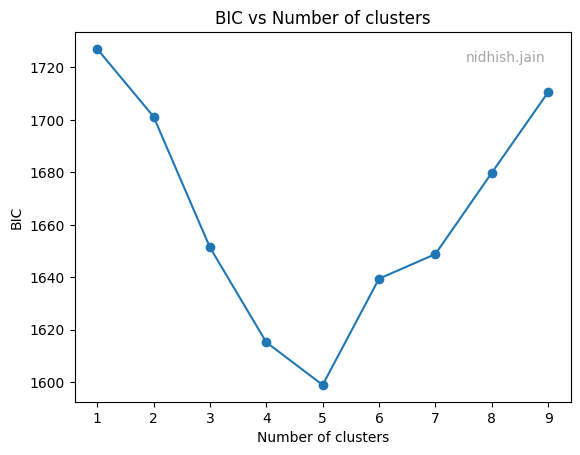

In [31]:
bic_vals = []
for cluster in range(1,10):
    bic = BIC(cluster)
    print(f"Number of clusters: {cluster}, BIC: {bic}")
    bic_vals.append(bic)

plt.plot(range(1,len(bic_vals)+1), bic_vals, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.title('BIC vs Number of clusters')
ac = plt.gca()
gmm_obj1._add_watermark(ac)
plt.show()

The optimal value of number of clusters using BIC is 5.

After which teh value starts to increase this is because of the reason that BIC penalizes the number of parameters so as we increase the number of clusters hence parameters like mean,variance also increases and this is penalized by the regularization term in BIC.

$$
BIC = -2\cdot ln(L) + k \cdot ln(n)
$$

This prevents model to add unnecessary clusters as it lets us know that we can get similar results even with less number of clusters.

### Silhouette Score

Number of clusters: 2, Silhouette Score: 0.1974620565070072
Number of clusters: 3, Silhouette Score: 0.2379592286712618
Number of clusters: 4, Silhouette Score: 0.3605407214033864
Number of clusters: 5, Silhouette Score: 0.3162257289402566
Number of clusters: 6, Silhouette Score: 0.20518294012960175
Number of clusters: 7, Silhouette Score: 0.2237005466045229
Number of clusters: 8, Silhouette Score: 0.2202036763918044
Number of clusters: 9, Silhouette Score: 0.19315941330677922


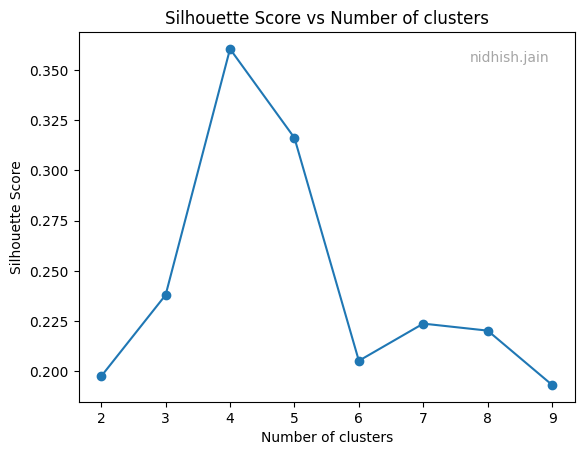

In [34]:
sil_vals = []
for cluster in range(2,10):
    gmm_obj = GMM(df_scaled, n_clusters=cluster, max_iters=100)
    gmm_obj.fit()
    membership = gmm_obj.getMembership()
    labels = np.argmax(membership, axis=1)
    
    # Calculate silhouette score
    sil_score = silhouette_score(df_scaled, labels)
    print(f"Number of clusters: {cluster}, Silhouette Score: {sil_score}")
    sil_vals.append(sil_score)

plt.plot(range(2,len(sil_vals)+2), sil_vals, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of clusters')
ac = plt.gca()
gmm_obj1._add_watermark(ac)
plt.show()

The best silhouette score is obtained for number of clusters = 4.

The silhouette score measures how similar is a point to its cluster and how different it is from other clusters.

$$
S(i) = \frac{b(i) - a(i)}{max(a(i), b(i))}
$$

where a(i) is the average distance of point i to all other points in its cluster and b(i) is the minimum average distance of point i to all points in other clusters. Final silhouette score is the average of S(i) for all points.

In case when the clusters are less than the value of a(i) will be high as the points will be far away from each other in the same cluster and hence the silhouette score will be low as it will be subtracted from b(i).

When the number of clusters are more, the value of b(i) will be low as the points will be close to other clusters and hence again the silhouette score will be low.